# Loading & Splitting Data

In [1]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import numpy as np
from sklearn.datasets import load_boston
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
boston = load_boston()
X = boston.data # housing features
y = boston.target # housing prices

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

# Train & Test Split Only (yucky)

In [4]:
def my_rmse(y_true, y_pred):
    mse = ((y_true - y_pred)**2).mean()
    return np.sqrt(mse)

In [5]:
foo = np.array([4,3,1,6,8])
bar = np.array([4,6,1,3,7])
print(my_rmse(foo,bar))
print(np.sqrt(mean_squared_error(foo,bar)))

1.9493588689617927
1.9493588689617927


In [6]:
# Fit your model using the training set
reg = KNeighborsRegressor()
reg.fit(X_train, y_train)

# Call predict to get the predicted values for training and test set
train_predicted = reg.predict(X_train)
test_predicted = reg.predict(X_test)

# Calculate RMSE for training and test set
print('RMSE for training set ', my_rmse(y_train, train_predicted))
print('RMSE for test set ', my_rmse(y_test, test_predicted))

RMSE for training set  5.004034467294172
RMSE for test set  6.382319080897923


When we evaluate our RMSE on a new set of data, we gain an understanding of how well we are 
capturing the signal in our data.  We can build more complex models that may bend to perfectly
fit our training data.  However, these models are not going to extend well to a new set of data,
because they are likely overfit to our training data.  

By evaluating our performance metric on a new set of data, we assure that we are modeling signal
and not the noise in our data.


# K-Fold Cross Validation (woo yeah)

In [7]:
def my_cross_val_score(X_data, y_data, num_folds=3):
    ''' Returns error for k-fold cross validation. '''
    kf = KFold(n_splits=num_folds)
    error = np.empty(num_folds)
    index = 0
    reg = KNeighborsRegressor()
    for train, test in kf.split(X_data):
        reg.fit(X_data[train], y_data[train])
        pred = reg.predict(X_data[test])
        error[index] = my_rmse(pred, y_data[test])
        index += 1
    return np.mean(error)

In [8]:
my_cross_val_score(X_train, y_train, num_folds=5)

6.283351851426688

"do k-fold cross validation where you limit the training set size by varying amounts"

This could mean either changing k (higher k means there is more data in the training folds), or fixing k and restricting the amount of data we use in the first place.

Let's try the latter first:

In [9]:
cv_scores = []
for n in range(20,300):
    cv_score = my_cross_val_score(X_train[:n], y_train[:n], num_folds=5)
    cv_scores.append(cv_score)

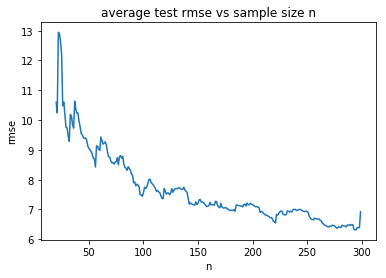

In [10]:
plt.plot(list(range(20,300)),cv_scores)
plt.xlabel('n')
plt.ylabel('rmse')
plt.title('average test rmse vs sample size n');

What if we use all the data and vary the number of folds?

In [11]:
cv_scores = []
for k in range(2,51):
    cv_score = my_cross_val_score(X_train, y_train, num_folds=k)
    cv_scores.append(cv_score)

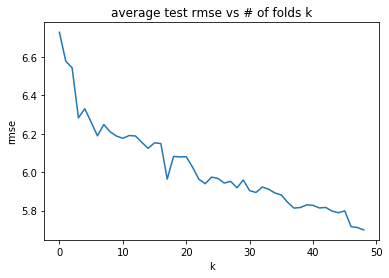

In [12]:
plt.plot(cv_scores)
plt.xlabel('k')
plt.ylabel('rmse')
plt.title('average test rmse vs # of folds k');

I like to see train error along with test error, so let's modify that function a bit

In [13]:
def my_cross_val_scores(X_data, y_data, num_folds=3):
    ''' Returns error for k-fold cross validation. '''
    kf = KFold(n_splits=num_folds)
    train_error = np.empty(num_folds)
    test_error = np.empty(num_folds)
    index = 0
    reg = KNeighborsRegressor()
    for train, test in kf.split(X_data):
        reg.fit(X_data[train], y_data[train])
        pred_train = reg.predict(X_data[train])
        pred_test = reg.predict(X_data[test])
        train_error[index] = my_rmse(pred_train, y_data[train])
        test_error[index] = my_rmse(pred_test, y_data[test])
        index += 1
    return np.mean(test_error), np.mean(train_error)

Here's rmse vs sample size:

In [14]:
cv_test_scores = []
cv_train_scores = []

for n in range(20,301):
    cv_test, cv_train = my_cross_val_scores(X_train[:n], y_train[:n], num_folds=5)
    cv_test_scores.append(cv_test)
    cv_train_scores.append(cv_train)

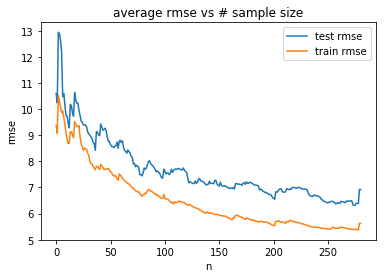

In [15]:
plt.plot(cv_test_scores, label='test rmse')
plt.plot(cv_train_scores, label='train rmse')
plt.xlabel('n')
plt.ylabel('rmse')
plt.title('average rmse vs # sample size')
plt.legend();

And vs # of folds:

In [16]:
cv_test_scores = []
cv_train_scores = []

for k in range(2,51):
    cv_test, cv_train = my_cross_val_scores(X_train, y_train, num_folds=k)
    cv_test_scores.append(cv_test)
    cv_train_scores.append(cv_train)

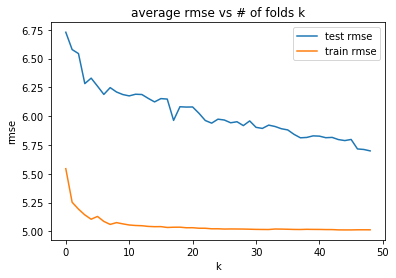

In [17]:
plt.plot(cv_test_scores, label='test rmse')
plt.plot(cv_train_scores, label='train rmse')
plt.xlabel('k')
plt.ylabel('rmse')
plt.title('average rmse vs # of folds k')
plt.legend();

# Stepwise Regression (extra credit)

In [18]:
from sklearn.datasets import make_friedman1

In [19]:
X_fri, y_fri = make_friedman1(n_samples=5000, n_features=100, random_state=0)

In [20]:
from itertools import combinations
from copy import deepcopy
from sklearn.metrics import r2_score
import quantecon as qe

def Eliminate_One(reg, X, y, included_features):
    '''
    Eliminate One
    For a provided regressor, evaluate the ideal subset of n-1 features to try from 
    a provided list of n features.  This function can be called itterative to perform
    recursive feature elimination for a general regression model (not leveraging feature
    importances).
    
    Inputs - 
    * reg = a regression model matching the sklearn mechanics
    * X, y = numpy arrays for the features and targets
    * included_features = numpy array indicating the column indexes to subset from
    '''
    best_r2 = -1
    best_reg = deepcopy(reg)
    best_features = None
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=13)
    print("*** Trying {} combinations of features.".format(included_features.shape[0]-1))
    for feats in combinations(included_features, included_features.shape[0]-1):
        reg.fit(X_train[:, feats], y_train)
        r2 = r2_score(y_test, reg.predict(X_test[:, feats]))
        if r2 > best_r2:
            best_r2 = r2
            best_reg = deepcopy(reg)
            best_features = np.array(feats)
    return best_reg, best_r2, best_features

In [21]:
n_samples = X_fri.shape[0]
n_features = X_fri.shape[1]
r2_scores = np.zeros(n_features)
adj_r2_scores = np.zeros(n_features)
feats = np.array(list(range(n_features)))

# Hint: consider debugging with 3 steps instead of all 100.
# N.B. this is a brute force approach, and will take a long time.  This is a nice demonstration
# of the practical drawbacks to KNN.  
for p in range(1, n_features):
    qe.util.tic()
    reg, r2, feats = Eliminate_One(KNeighborsRegressor(n_neighbors=10), X_fri, y_fri, feats)
    qe.util.toc()
    adj_r2 = 1 - ((1 - r2)*(n_samples - 1)/(n_samples - (n_features - p) - 1))
    r2_scores[p-1] = r2
    adj_r2_scores[p-1] = adj_r2
    print("With {0} features eliminated we have an adjusted R^2 of {1:.3f}".format(p, adj_r2))

*** Trying 99 combinations of features.
TOC: Elapsed: 0:01:35.43
With 1 features eliminated we have an adjusted R^2 of 0.273
*** Trying 98 combinations of features.
TOC: Elapsed: 0:01:23.86
With 2 features eliminated we have an adjusted R^2 of 0.275
*** Trying 97 combinations of features.
TOC: Elapsed: 0:01:29.00
With 3 features eliminated we have an adjusted R^2 of 0.267
*** Trying 96 combinations of features.
TOC: Elapsed: 0:01:26.92
With 4 features eliminated we have an adjusted R^2 of 0.286
*** Trying 95 combinations of features.
TOC: Elapsed: 0:01:24.73
With 5 features eliminated we have an adjusted R^2 of 0.266
*** Trying 94 combinations of features.
TOC: Elapsed: 0:01:24.91
With 6 features eliminated we have an adjusted R^2 of 0.276
*** Trying 93 combinations of features.
TOC: Elapsed: 0:01:19.83
With 7 features eliminated we have an adjusted R^2 of 0.276
*** Trying 92 combinations of features.
TOC: Elapsed: 0:01:21.74
With 8 features eliminated we have an adjusted R^2 of 0.283


TOC: Elapsed: 0:00:8.34
With 66 features eliminated we have an adjusted R^2 of 0.529
*** Trying 33 combinations of features.
TOC: Elapsed: 0:00:7.94
With 67 features eliminated we have an adjusted R^2 of 0.540
*** Trying 32 combinations of features.
TOC: Elapsed: 0:00:7.69
With 68 features eliminated we have an adjusted R^2 of 0.532
*** Trying 31 combinations of features.
TOC: Elapsed: 0:00:7.34
With 69 features eliminated we have an adjusted R^2 of 0.556
*** Trying 30 combinations of features.
TOC: Elapsed: 0:00:6.97
With 70 features eliminated we have an adjusted R^2 of 0.550
*** Trying 29 combinations of features.
TOC: Elapsed: 0:00:6.55
With 71 features eliminated we have an adjusted R^2 of 0.550
*** Trying 28 combinations of features.
TOC: Elapsed: 0:00:6.27
With 72 features eliminated we have an adjusted R^2 of 0.563
*** Trying 27 combinations of features.
TOC: Elapsed: 0:00:5.76
With 73 features eliminated we have an adjusted R^2 of 0.563
*** Trying 26 combinations of features.


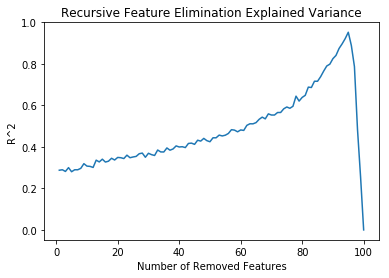

In [29]:
plt.plot(np.arange(1,n_features +1), r2_scores)
plt.title('Recursive Feature Elimination Explained Variance')
plt.xlabel('Number of Removed Features')
plt.ylabel('R^2');

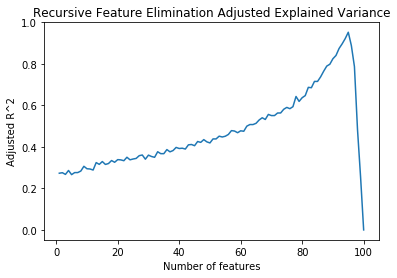

In [30]:
plt.plot(np.arange(1,n_features +1), adj_r2_scores)
plt.title('Recursive Feature Elimination Adjusted Explained Variance')
plt.xlabel('Number of features')
plt.ylabel('Adjusted R^2');